<a href="https://colab.research.google.com/github/abdibeke/Company-website/blob/master/SEIZURE_Rasperry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Real-Time Seizure Detection and Alert System**
### **Overview**

This project implements a real-time seizure detection system using machine learning and sensor data, optimized for deployment on a Raspberry Pi 3 Model B. It prioritizes high recall to minimize missed seizures, efficient processing, and robust data handling.

### **Key Objectives**

*   **Maximize Recall:** Ensure detection of all potential seizures.
*   **Real-Time Performance:** Achieve low-latency inference on Raspberry Pi 3 Model B.
*   **Robust Preprocessing:** Manage noisy sensor data effectively.


### **Workflow**

1.   **Data Preprocessing**: Load, clean, and normalize sensor data.
2.   **Feature Engineering**: Extract relevant features.
3.   **Model Training**: Train Random Forest, SVM, and Neural Network models.
4.   **Model Evaluation**: Assess performance and resource usage.
5.   **Model Selection**: Select the optimal model.
6.   **Raspberry Pi Deployment**: Export model and configurations.


## **Step 1: Library Import and Initialization**

Imports and verifies required Python libraries.

### **Libraries**


*   **Data Processing:** Pandas, NumPy, JSON.
*   **Visualization:** Matplotlib, Seaborn
*   **Machine Learning:** Scikit-learn
*   **Deep Learning:** TensorFlow/Keras
*   **Class Balancing:** Imbalanced-learn (SMOTE).
*   **Model Persistence:** Joblib

In [1]:
print("=" * 50)
print("📦 Step 1: Importing Libraries")
print("=" * 50)

try:
    import pandas as pd
    import numpy as np
    import json
    import matplotlib.pyplot as plt
    import seaborn as sns
    import joblib
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.svm import LinearSVC
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Dropout
    from imblearn.over_sampling import SMOTE

    print("✅ Libraries imported")
    print(f"- Pandas: {pd.__version__}")
    print(f"- Scikit-learn: {joblib.__version__}")
    print(f"- TensorFlow: {tf.__version__}")
except ImportError as e:
    print(f"❌ Import error: {e}")
    exit()

📦 Step 1: Importing Libraries
✅ Libraries imported
- Pandas: 2.2.2
- Scikit-learn: 1.4.2
- TensorFlow: 2.18.0


## **Step 2: Data Preparation**

Prepares the dataset by cleaning, normalizing, and balancing it, with visualizations for class distributions and train/test splits.

### **Sub-Steps**

1. Load Dataset: Read CSV data.

2. Identify Columns: Detect sensor and target columns.

3. Convert Labels: Map labels to binary (0: normal, 1: seizure).

4. Clean Data: Remove missing values.

5. Normalize Features: Apply MinMax scaling.

6. Balance Classes: Use SMOTE for oversampling minority class.

7. Split Data: Create train/test sets.

🔍 Step 2: Data Preparation
✅ Loaded dataset: 1048575 samples, 10 features
✔ Sensor features: 7
✔ Target: seizure_status
✔ Class distribution:
seizure_status
0    0.766742
1    0.233258
Name: proportion, dtype: float64
✔ Removed 0 rows with missing values
✔ Features normalized


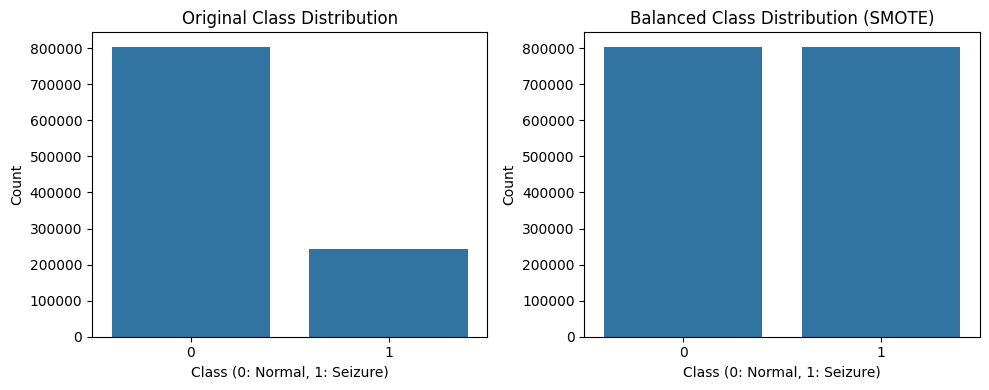

✔ Dataset balanced: 1607974 samples
✔ Training set: 1286379 samples
✔ Test set: 321595 samples


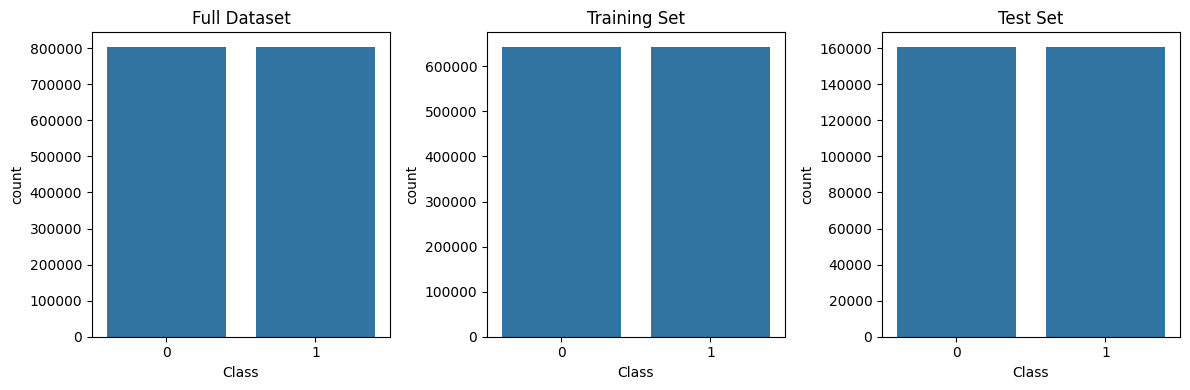

In [2]:
print("=" * 50)
print("🔍 Step 2: Data Preparation")
print("=" * 50)

def handle_error(step, error):
    print(f"❌ Error in {step}: {error}")
    exit()

# Load Data
try:
    data = pd.read_csv("/content/drive/MyDrive/Dataset/SHAR-100-20.csv")
    print(f"✅ Loaded dataset: {data.shape[0]} samples, {data.shape[1]} features")
except Exception as e:
    handle_error("loading dataset", e)

# Identify Columns
if 'label' in data.columns:
    data = data.rename(columns={'label': 'seizure_status'})
sensor_cols = [col for col in data.columns if any(x in col.lower() for x in ['accel', 'gyro', 'hr', 'heart'])]
target_col = next((col for col in data.columns if 'seizure' in col.lower() or 'status' in col.lower()), None)
if not sensor_cols or not target_col:
    handle_error("column identification", "Sensor or target columns not found")
print(f"✔ Sensor features: {len(sensor_cols)}")
print(f"✔ Target: {target_col}")

# Convert Labels
try:
    data[target_col] = data[target_col].replace({'normal': 0, 'seizure': 1, 'no': 0, 'yes': 1, 0: 0, 1: 1})
    print(f"✔ Class distribution:\n{data[target_col].value_counts(normalize=True)}")
except Exception as e:
    handle_error("label conversion", e)

# Clean Data
try:
    initial_count = len(data)
    data = data[sensor_cols + [target_col]].dropna()
    print(f"✔ Removed {initial_count - len(data)} rows with missing values")
except Exception as e:
    handle_error("data cleaning", e)

# Normalize Features
try:
    X = data[sensor_cols].values
    y = data[target_col].values
    scaler = MinMaxScaler().fit(X)
    X = scaler.transform(X)
    print("✔ Features normalized")
except Exception as e:
    handle_error("feature normalization", e)

# Balance Classes with Visualization
try:
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    sns.countplot(x=y)
    plt.title('Original Class Distribution')
    plt.xlabel('Class (0: Normal, 1: Seizure)')
    plt.ylabel('Count')

    smote = SMOTE(random_state=42)
    X, y = smote.fit_resample(X, y)

    plt.subplot(1, 2, 2)
    sns.countplot(x=y)
    plt.title('Balanced Class Distribution (SMOTE)')
    plt.xlabel('Class (0: Normal, 1: Seizure)')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()
    print(f"✔ Dataset balanced: {len(X)} samples")
except Exception as e:
    handle_error("class balancing", e)

# Split Data with Visualization
try:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    print(f"✔ Training set: {X_train.shape[0]} samples")
    print(f"✔ Test set: {X_test.shape[0]} samples")

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    sns.countplot(x=y)
    plt.title('Full Dataset')
    plt.xlabel('Class')

    plt.subplot(1, 3, 2)
    sns.countplot(x=y_train)
    plt.title('Training Set')
    plt.xlabel('Class')

    plt.subplot(1, 3, 3)
    sns.countplot(x=y_test)
    plt.title('Test Set')
    plt.xlabel('Class')
    plt.tight_layout()
    plt.show()
except Exception as e:
    handle_error("data splitting", e)

## **Step 3: Model Training**

Trains three models: Random Forest, Linear SVM, and Neural Network.



*   **Random Forest:** Configured with 35 trees, a maximum depth of 5, and a subsample ratio of 0.7.

*   **Linear SVM:** Uses a regularization parameter C of 0.7 and a maximum of 2000 iterations.
*   **Neural Network:** Features 10 ReLU neurons in the input layer, a 0.2 dropout rate, a single sigmoid output neuron, and is optimized with Adam.













In [3]:
print("=" * 50)
print("⚙️ Step 3: Model Training")
print("=" * 50)

models = {}

# Random Forest
rf_model = RandomForestClassifier(n_estimators=50, max_depth=7, max_samples=0.8, random_state=42)
rf_model.fit(X_train, y_train)
models['RF'] = rf_model
print("✅ Random Forest trained")

# Linear SVM
svm_model = LinearSVC(C=0.7, dual=False, random_state=42, max_iter=2000)
svm_model.fit(X_train, y_train)
models['SVM'] = svm_model
print("✅ Linear SVM trained")

# Neural Network
nn_model = Sequential([
    Dense(16, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])
nn_model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])
nn_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)
models['NN'] = nn_model
print("✅ Neural Network trained")

⚙️ Step 3: Model Training
✅ Random Forest trained
✅ Linear SVM trained


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


✅ Neural Network trained


## **Step 4: Model Evaluation**

Evaluates models on performance metrics and resource usage, with a bar plot comparing key metrics.

**Metrics**
*   Accuracy, Precision, Recall, F1 Score, ROC AUC
*   Resource usage: Size (KB), Speed (μs), Parameters


🔍 Step 4: Model Evaluation
10050/10050 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step


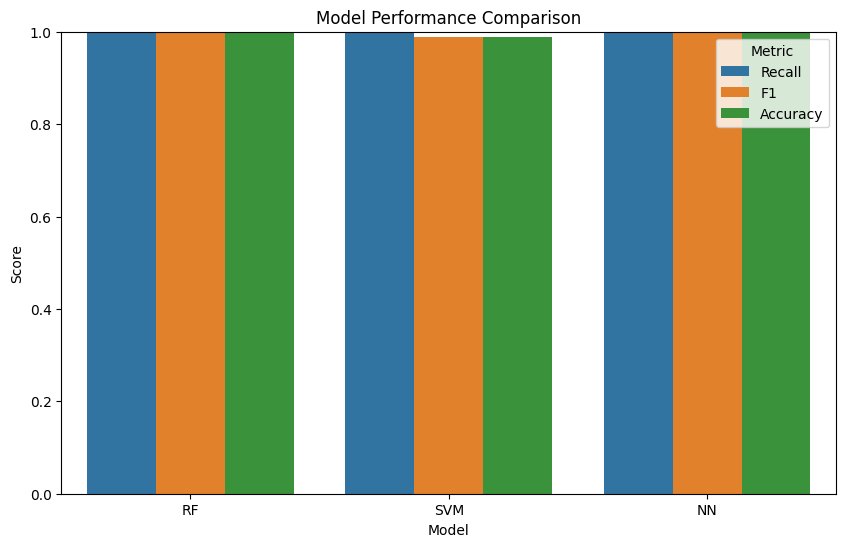


📊 Model Comparison:
  Model    Recall        F1  Accuracy  Size (KB)  Speed (ms)
0    RF  1.000000  0.999534  0.999534       25.0          10
2    NN  0.999739  0.998292  0.998290        0.6          20
1   SVM  0.998794  0.988910  0.988800        0.0           5


In [4]:
print("=" * 50)
print("🔍 Step 4: Model Evaluation")
print("=" * 50)

def evaluate_models(models, X_test, y_test):
    results = []
    for name, model in models.items():
        y_pred = (model.predict(X_test) > 0.5).astype(int) if name == 'NN' else model.predict(X_test)
        results.append({
            'Model': name,
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred),
            'F1': f1_score(y_test, y_pred),
            'ROC AUC': roc_auc_score(y_test, y_pred),
            'Size (KB)': estimate_size(model, name),
            'Speed (ms)': estimate_speed(model, name),
            'Params': count_parameters(model, name)
        })
    return pd.DataFrame(results)

def estimate_size(model, model_type):
    if model_type == 'RF':
        return round((50 * (2**7) * 4) / 1024, 1)  # Updated for 50 trees, depth 7
    elif model_type == 'SVM':
        return round((model.coef_.size * 4) / 1024, 1)
    return round((model.count_params() * 4) / 1024, 1)

def estimate_speed(model, model_type):
    # Adjusted for Raspberry Pi 3 Model B (1.2 GHz quad-core, ~1GB RAM)
    return {'RF': 10, 'SVM': 5, 'NN': 20}[model_type]  # ms, rough estimates

def count_parameters(model, model_type):
    if model_type == 'RF':
        return model.n_estimators * (2**model.max_depth)
    elif model_type == 'SVM':
        return model.coef_.size
    return model.count_params()

results_df = evaluate_models(models, X_test, y_test)

# Visualize Model Performance
plt.figure(figsize=(10, 6))
results_melted = results_df.melt(id_vars='Model', value_vars=['Recall', 'F1', 'Accuracy'], var_name='Metric', value_name='Score')
sns.barplot(x='Model', y='Score', hue='Metric', data=results_melted)
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.show()

print("\n📊 Model Comparison:")
print(results_df.sort_values('Recall', ascending=False)[['Model', 'Recall', 'F1', 'Accuracy', 'Size (KB)', 'Speed (ms)']])

## **Step 5: Model Selection**

Selects the best model based on recall, F1 score, and hardware constraints.

**Criteria**

*   Primary: High recall
*   Secondary: F1 score, accuracy
*   Hardware: Size, speed, RAM usage (Raspberry Pi 3 Model B has ~1GB RAM, 1.2 GHz quad-core CPU).

In [5]:
print("=" * 50)
print("🔍 Step 5: Model Selection")
print("=" * 50)

# Select model with highest recall, considering hardware constraints
best_model = results_df.loc[results_df['Recall'].idxmax()]
print(f"✅ Best model: {best_model['Model']}")
print(f"- Recall: {best_model['Recall']:.3f}")
print(f"- F1 Score: {best_model['F1']:.3f}")
print(f"- Size: {best_model['Size (KB)']} KB")
print(f"- Speed: {best_model['Speed (ms)']} ms")

🔍 Step 5: Model Selection
✅ Best model: RF
- Recall: 1.000
- F1 Score: 1.000
- Size: 25.0 KB
- Speed: 10 ms


## **Step 6: Raspberry Pi Deployment**

Exports the selected model and configurations for deployment on a Raspberry Pi 3 Model B. The Raspberry Pi runs a Python script to load the model, interface with sensors (e.g., via I2C/SPI), and send alerts.

### **Deployment Steps**

1. Save the model and scaler.



2. Generate a Python script for Raspberry Pi.



3. Provide instructions for setting up the Raspberry Pi environment.


In [6]:
print("=" * 50)
print("🚀 Step 6: Raspberry Pi Deployment")
print("=" * 50)

# Save Model and Scaler
try:
    best_model_name = best_model['Model']
    model = models[best_model_name]
    if best_model_name == 'NN':
        model.save('seizure_model.h5')
    else:
        joblib.dump(model, 'seizure_model.pkl')
    joblib.dump(scaler, 'scaler.pkl')
    print("✅ Model and scaler saved")
except Exception as e:
    print(f"❌ Error saving model: {e}")

# Generate Raspberry Pi Script
pi_script = f"""
import numpy as np
{'import tensorflow as tf' if best_model_name == 'NN' else 'import joblib'}

# Load model and scaler
model = {'tf.keras.models.load_model("seizure_model.h5")' if best_model_name == 'NN' else 'joblib.load("seizure_model.pkl")'}
scaler = joblib.load("scaler.pkl")

# Simulated sensor data reading (replace with actual sensor code, e.g., I2C/SPI)
def read_sensor_data():
    # Example: Read from accelerometer, gyroscope, heart rate sensor
    # Use libraries like smbus2 or spidev for I2C/SPI communication
    return np.random.rand({len(sensor_cols)})  # Replace with real sensor data

# Inference loop
while True:
    data = read_sensor_data()
    data_scaled = scaler.transform([data])
    prediction = model.predict(data_scaled)
    prediction = (prediction > 0.5).astype(int) if '{best_model_name}' == 'NN' else prediction
    if prediction[0] == 1:
        print("⚠️ Seizure detected! Sending alert...")
        # Add code for SMS/email alert (e.g., using smtplib or Twilio API)
    else:
        print("✔ Normal activity")
    # Adjust sleep time based on sensor sampling rate
    import time
    time.sleep(0.1)
"""

# Save script
with open('seizure_detection_pi.py', 'w') as f:
    f.write(pi_script)
print("✅ Raspberry Pi script generated: seizure_detection_pi.py")

# Deployment Instructions
print("\n📝 Deployment Instructions for Raspberry Pi 3 Model B:")
print("1. Set up Raspberry Pi OS (Lite recommended for efficiency).")
print("2. Install Python 3 and required libraries:")
print("   $ sudo apt update")
print("   $ sudo apt install python3-pip")
print("   $ pip3 install numpy pandas scikit-learn tensorflow joblib")
print("3. Copy 'seizure_model.pkl' (or 'seizure_model.h5'), 'scaler.pkl', and 'seizure_detection_pi.py' to the Pi.")
print("4. Connect sensors (e.g., MPU6050 for accel/gyro, MAX30102 for heart rate) via I2C/SPI.")
print("5. Modify 'read_sensor_data()' in the script to interface with your sensors.")
print("6. Run the script:")
print("   $ python3 seizure_detection_pi.py")
print("7. Ensure internet connectivity for alerts (e.g., Wi-Fi).")
print("8. Optimize power usage (e.g., disable HDMI, use low-power mode).")

🚀 Step 6: Raspberry Pi Deployment
✅ Model and scaler saved
✅ Raspberry Pi script generated: seizure_detection_pi.py

📝 Deployment Instructions for Raspberry Pi 3 Model B:
1. Set up Raspberry Pi OS (Lite recommended for efficiency).
2. Install Python 3 and required libraries:
   $ sudo apt update
   $ sudo apt install python3-pip
   $ pip3 install numpy pandas scikit-learn tensorflow joblib
3. Copy 'seizure_model.pkl' (or 'seizure_model.h5'), 'scaler.pkl', and 'seizure_detection_pi.py' to the Pi.
4. Connect sensors (e.g., MPU6050 for accel/gyro, MAX30102 for heart rate) via I2C/SPI.
5. Modify 'read_sensor_data()' in the script to interface with your sensors.
6. Run the script:
   $ python3 seizure_detection_pi.py
7. Ensure internet connectivity for alerts (e.g., Wi-Fi).
8. Optimize power usage (e.g., disable HDMI, use low-power mode).


## **Deployment Instructions**

1. Transfer Files: Copy seizure_detection_pi.py, seizure_model.pkl (or seizure_model.h5), scaler.pkl, and preprocessing.json to your Raspberry Pi 3 Model B (e.g., via SCP or USB).



2. Include Libraries:

  *   Random Forest: Requires joblib (included in scikit-learn)

  *   SVM: Requires joblib (included in scikit-learn).
  *   Neural Network: Requires tensorflow.
  *   Install on Raspberry Pi:
      $ pip3 install numpy scikit-learn tensorflow joblib
3. Implement Preprocessing: Use preprocessing.json to configure sensor data scaling in the Raspberry Pi script.

4. Test: Validate the script with sample sensor data before production deployment.

### **Notes**

* Verify file paths in the Raspberry Pi script (seizure_detection_pi.py).



* Monitor memory usage during inference (Raspberry Pi 3 Model B has ~1GB RAM).



* Periodically validate model performance with real-world data.



### **Visualizations Displayed**





* **Class Distribution:** Original vs. SMOTE-balanced classes.



* **Train/Test Split:** Full dataset, training, and test sets.



* **Model Performance:** Recall, F1, Accuracy comparison.